# Comparing Watson's personality-trait percentile scores against numerical (raw) questionnaire scores can underestimate the statistical significance of correlations between Watson and questionnaires

IBM Watson provides personality-insight scores in the form of percentiles that compare the subject to the general population. By contrast, personality questionnaires return raw numerical scores that are typically then converted to population percentiles in a subsequent step. The questionnaire used in the recent personality study to assess the "Big Five" personality traits computes an integer score between 10 and 50 for each personality trait. Each trait's score was rescaled to a floating-point number in the interval [0, 1]. These rescaled questionnaire scores were then compared against Watson's percentile scores using correlation analysis (Pearson's *r*). For 4 out of 5 traits, this approach found no significant correlation between questionnaire and Watson scores.

The approach described above compares raw questionnaire scores against *population percentile* scores estimated by Watson. Watson does not output estimates of questionnaire scores -- and if it does, we have no access to those estimates.

**Potential problem:** raw questionnaire scores should follow a gaussian distribution, but their general-population percentiles will be distributed much flatter. Transforming raw scores to percentiles is nonlinear, but preserves rank-ordering.
**Questions:**
- Could there be correlations hiding in the current data that our initial correlation analysis missed?
- Does Spearman's rank-order correlation coefficient reveal these hidden correlations?

**Outline of this notebook:**
1. Limit scope to a single personality trait; it doesn't matter which one.
2. For this trait, assume an underlying normal distribution of questionnaire scores that governs the general population.
2. Randomly draw 38 people from that population.
3. Save each person's questionnaire score, as well as their percentile score within the general population. (This percentile score is what Watson would output if it had perfect accuracy.)
4. For each person, simulate a "noisy" questionnaire score by adding zero-mean gaussian noise. Ensure this noisy score still falls between 10 and 50 inclusive. (This is the questionnaire score that we wish Watson would estimate for us; unfortunately, it only exposes estimates of population percentile.)
5. For each person, convert their noisy questionnaire score into a population percentile. (This is what Watson does internally, giving us the percentile but not the estimated questionnaire score.)
6. Vary the amount of added noise; see if Pearson's correlation is ever significant for true versus noisy questionnaire score, but **not** significant for true questionnaire score versus noisy *percentile* score.
7. See if Spearman's rho picks up significance where Pearson's *r* does not.

In [1]:
import pandas as pd
import numpy as np
import seaborn.apionly as sns
# Use norm.cdf to convert questionnaire score to percentile
from scipy.stats import pearsonr, spearmanr, norm
import matplotlib.pyplot as plt
%matplotlib inline

For each big-five trait, the questionnaire yields a score between 10 and 50. N was 38. Let's draw 38 questionnaire instances from a normal distribution with mean 30 and standard deviation 7, which is roughly realistic, if I recall correctly.

In [2]:
N = 38
score_mean = 30.
score_std = 7.
np.random.seed(12345)

In [3]:
questionnaire_scores = np.random.normal(loc=score_mean, scale=score_std, size=N).astype(np.int16)
# Reassign any scores that fall outside the acceptable range
questionnaire_scores[questionnaire_scores > 50] = 50
questionnaire_scores[questionnaire_scores < 10] = 10

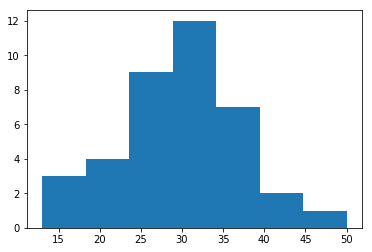

In [4]:
plt.hist(questionnaire_scores, bins='auto');

Next, we need the *population* percentiles of each of these scores. If Watson had perfect accuracy, the following `percentiles` array would be its output.

In [5]:
percentiles = norm.cdf(questionnaire_scores, loc=score_mean, scale=score_std)

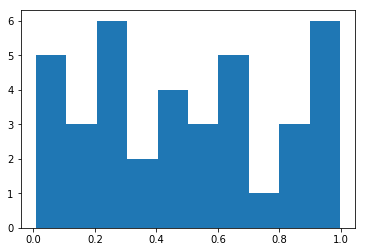

In [6]:
plt.hist(percentiles);

Sanity check: this should look sigmoidal.

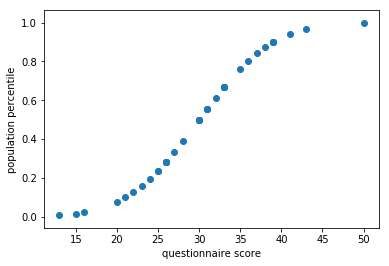

In [7]:
plt.scatter(questionnaire_scores, percentiles);
plt.xlabel('questionnaire score')
plt.ylabel('population percentile');

Of course, Watson ain't perfect. Let's degrade the above perfect mapping of questionnaire score -> population percentile. We'll do this by first adding random gaussian noise to the raw questionnaire scores, then converting the resulting noisy scores into population percentile scores, which we'll call `noisy_percentiles`.

## Generate noisy questionnaire scores

In [8]:
noise_std = 12  # Play around with this, and remember to reseed the random number generator between runs
noisy_scores = questionnaire_scores + np.random.normal(loc=0, scale=noise_std, size=N).astype(np.int16)
# reassign any scores that fall outside the acceptable range
noisy_scores[noisy_scores > 50] = 50
noisy_scores[noisy_scores < 10] = 10

This should look noisy but linear:

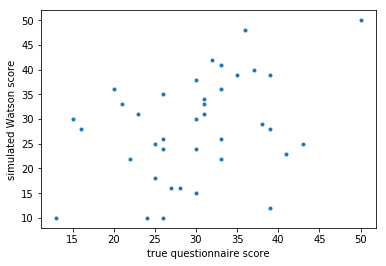

In [9]:
plt.plot(questionnaire_scores, noisy_scores, marker='.', linestyle='');
plt.xlabel('true questionnaire score');
plt.ylabel('simulated Watson score');

In [10]:
pearsonr(questionnaire_scores, noisy_scores)

(0.37261073759533719, 0.021230558890388086)

## Generate noisy population percentiles

Convert noisy questionnaire scores to their population percentiles. (This is what Watson does internally, without ever giving us the estimated questionnaire scores directly.)

In [11]:
noisy_percentiles = norm.cdf(noisy_scores, loc=score_mean, scale=score_std)

The following plot should look like a clean sigmoid curve, but with scrambled horizontal positions compared to the sigmoid curve above:

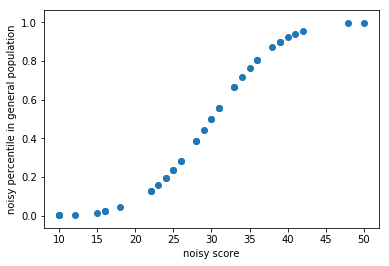

In [12]:
plt.scatter(noisy_scores, noisy_percentiles);
plt.xlabel('noisy score')
plt.ylabel('noisy percentile in general population');

This should look noisy:

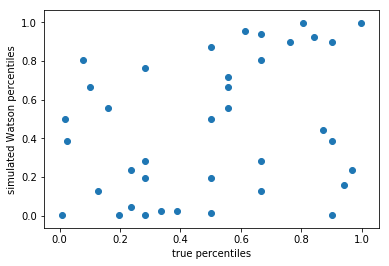

In [13]:
plt.scatter(percentiles, noisy_percentiles);
plt.xlabel('true percentiles')
plt.ylabel('simulated Watson percentiles');

In [14]:
print 'Pearson\'s r and p-value:'
print pearsonr(percentiles, noisy_percentiles)

Pearson's r and p-value:
(0.30985630286825111, 0.058335752018840337)


Rescale questionnaire scores to fit into the interval [0, 1]:

In [15]:
normalized_questionnaire_scores = (questionnaire_scores - 10)/(50. - 10.)
normalized_noisy_scores = (noisy_scores - 10)/(50. - 10.)

## What the study currently does: compare the (normalized) questionnaire score to Watson's population percentiles

In [16]:
# Prep data for linear model plotting
df1 = pd.DataFrame(np.array([normalized_questionnaire_scores, noisy_percentiles]).T, 
                  columns=['True questionnaire score', 'Simulated Watson percentile'])

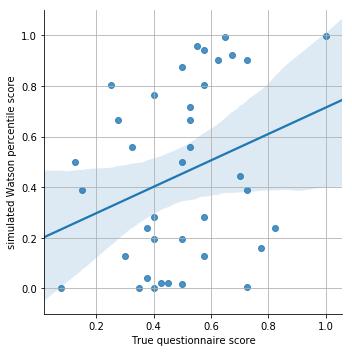

In [17]:
sns.lmplot(x='True questionnaire score', y='Simulated Watson percentile', data=df1);
plt.xlabel('True questionnaire score');
plt.ylabel('simulated Watson percentile score');
plt.ylim(-0.1, 1.1);
plt.grid()

In [18]:
print 'Pearson\'s r, p-value:'
pearsonr(normalized_questionnaire_scores, noisy_percentiles)

Pearson's r, p-value:


(0.29421567251435926, 0.072972629956098697)

### Not significant (*p* = 0.07); low Pearson's *r* = 0.294. But...

## This is the correlation analysis that we *would* run, if only Watson gave us estimates of questionnaire scores instead of population percentiles

In [19]:
# Prep data for linear model plotting
df2 = pd.DataFrame(np.array([normalized_questionnaire_scores, normalized_noisy_scores]).T, 
                  columns=['True questionnaire score', 'Simulated Watson questionnaire score'])

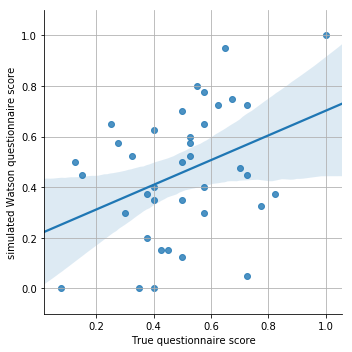

In [20]:
sns.lmplot(x='True questionnaire score', y='Simulated Watson questionnaire score', data=df2);
plt.xlabel('True questionnaire score');
plt.ylabel('simulated Watson questionnaire score');
plt.ylim(-0.1, 1.1);
plt.grid()

In [21]:
print 'Pearson\'s r, p-value:'
pearsonr(normalized_questionnaire_scores, normalized_noisy_scores)

Pearson's r, p-value:


(0.37261073759533736, 0.021230558890388031)

### Significant (*p* = 0.02); higher Pearson's *r* = 0.373!

### Visualizing the effect of moving from raw questionnaire scores to population percentiles

Using population percentiles smooths out the peak of the normal distribution, increasing the vertical spread in a plot of true questionnaire score versus measured questionnaire score. Here's one way to graph this effect.

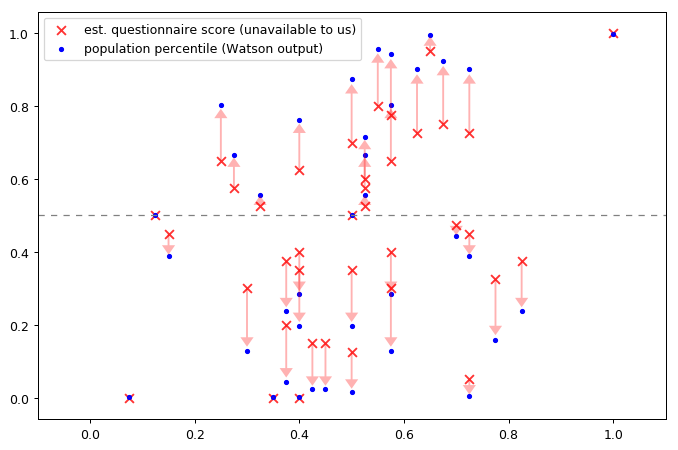

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), dpi=90)
ax.scatter(normalized_questionnaire_scores, 
           normalized_noisy_scores, 
           alpha=0.8,
           color='r',
           marker='x',
           s=50);
ax.scatter(normalized_questionnaire_scores, 
           noisy_percentiles, 
           color='b',
           s=10);
ax.quiver(normalized_questionnaire_scores, 
          normalized_noisy_scores, 
          [0]*N, 
          noisy_percentiles - normalized_noisy_scores,
          color='r',
          alpha=0.3,
          width=0.003,
          headwidth=7,
          headaxislength=5,
          angles='xy');
ax.legend(['est. questionnaire score (unavailable to us)', 'population percentile (Watson output)']);
ax.axhline(0.5, color='grey', linewidth=1, linestyle='--', dashes=(5, 5));
plt.xlim(-0.1, 1.1);

Intuitively, you can see how plotting x = true questionnaire score and y = Watson-estimated percentile should always result in a *worse* Pearson correlation coefficient than x = true questionnaire score and y = Watson-estimated questionnaire scores (which we don't get).

## Spearman's Rank Correlation Coefficient

The following results should all be identical, since the nonlinear transformation of questionnaire score to population percentile preserves rank.

In [23]:
print spearmanr(questionnaire_scores, noisy_percentiles)
print spearmanr(normalized_questionnaire_scores, noisy_percentiles)
print spearmanr(normalized_questionnaire_scores, normalized_noisy_scores)

SpearmanrResult(correlation=0.33121187633093307, pvalue=0.042228818506382326)
SpearmanrResult(correlation=0.33121187633093307, pvalue=0.042228818506382326)
SpearmanrResult(correlation=0.33121187633093307, pvalue=0.042228818506382326)


# Conclusions

It's *technically* possible for Pearson's *r* (correlation coefficient) to be thrown off by comparing raw scores from a questionnaire to population percentile scores from Watson. However, this is a minor effect that won't rescue the lousy results reported to date.

I haven't been able to concoct a pathological example in which $p \gg 0.05$ for **raw score versus Watson *percentile***, but with $p < 0.05$ for **raw score versus Watson *score*.**

The fact that Watson's big-five percentiles are strongly correlated with one another is pretty damning. Even if we had access to Watson's estimates of raw questionnaire scores, we'd find the same correlations: Watson seems to be internally inconsistent on this datset.